In [1]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN

from matplotlib import pyplot as plt
import numpy as np

In [2]:
class VRLoss(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = self.cosinesim1(output, target)
        sim2 = self.cosinesim2(output, target)

        l = sim1.square().exp().mean() + sim2.square().exp().mean()
        return l

In [3]:
dataset = EncoderDecoderStaticDataset('/home/shivam/DKLabs/OilGasProject/WellLogCorrelation/data')
dataloader = DataLoader(dataset, batch_size = 10, shuffle = True, num_workers = 4)
data_len = len(dataloader)
log_n = int(data_len//2)

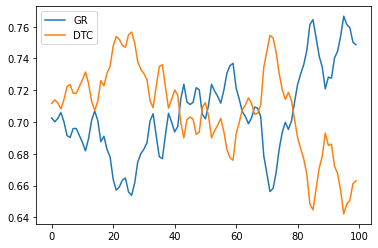

In [4]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = EncoderDecoder1DCNN(2, 50, activation=nn.PReLU)
model.to(device)
model.train()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): PReLU(num_parameters=1)
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,), bias=False)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PReLU(num_parameters=1)
    (5): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (6): PReLU(num_parameters=1)
    (7): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,), bias=False)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (11): PReLU(num_parameters=1)
    (12): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): PReLU(num_parameters=1)
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), s

In [10]:
criterion =  torch.nn.MSELoss() # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [11]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [12]:
rll = []
total_loss = []
model.train()
for epoch in range(500):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

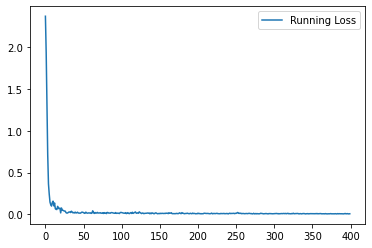

In [18]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

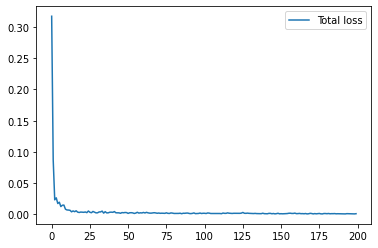

In [19]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [20]:
torch.save(model.state_dict(), './modelstate_l2_norm_modified_network_run2')

In [22]:
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

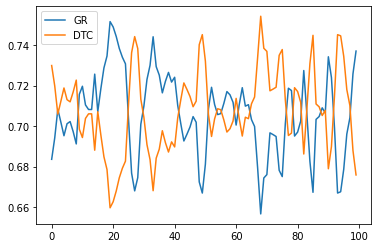

In [23]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [25]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(sample_data_)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

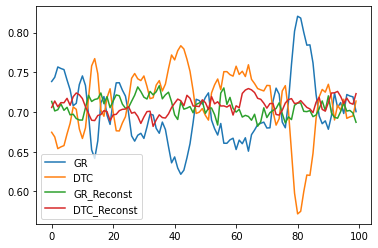

In [27]:
sample_data = dataset.__getitem__(0)
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.plot(reconst_data[0, :], label='GR_Reconst')
plt.plot(reconst_data[1, :], label='DTC_Reconst')
plt.legend()
plt.show()